In [1]:
%matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from particle_tracker_one_d import ParticleTracker

In [8]:
filename = 'simulated_diffusivity.mat'
data = scipy.io.loadmat(filename)

intensity = 1 - data['simulated']['responce2'][0][0]
time = np.arange(0,intensity.shape[0])*data['simulated']['dt2'][0][0][0]
normalised_intensity = ParticleTracker.normalise_intensity(intensity)


normalised_intensity = ParticleTracker.normalise_intensity(intensity)
pt = ParticleTracker(intensity=normalised_intensity, time=time)

<IPython.core.display.Javascript object>


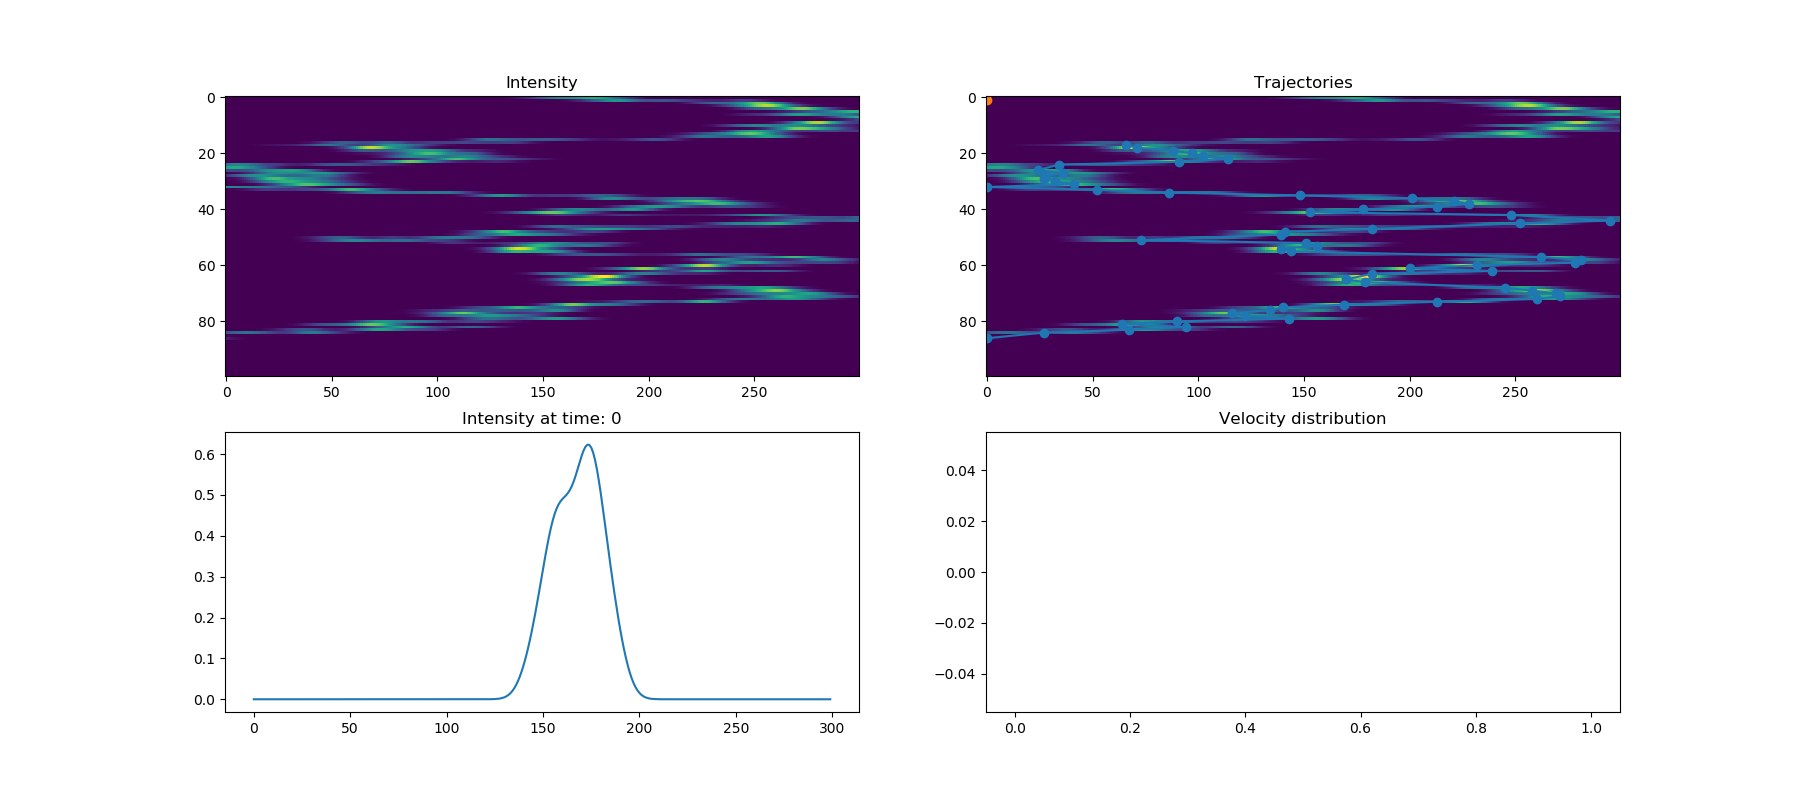

Output()

Output()

In [11]:
figure_with_trajectory_analysis =  plt.figure(figsize=(18,8))

ax_intensity = plt.subplot(221)
ax_trajectories = plt.subplot(222)
ax_intensity_at_time = plt.subplot(223)
ax_velocity_histogram = plt.subplot(224)

ax_trajectories.set_title('Trajectories')
ax_intensity_at_time.set_title('Intensity')
ax_velocity_histogram.set_title('Velocity distribution')


def reset_axes_titles_and_labels():
    ax_intensity_at_time.cla()
    ax_trajectories.cla()
    ax_velocity_histogram.cla()
    ax_intensity.cla()
    ax_intensity.set_title('Intensity')
    ax_trajectories.set_title('Trajectories')
    ax_intensity_at_time.set_title('Intensity')
    ax_velocity_histogram.set_title('Velocity distribution')
                               

def plot_trajectory_analysis(boxcar_width, feature_point_threshold, max_time_diff, expected_particle_width, max_travel):
    pt.boxcar_width=boxcar_width
    pt.feature_point_threshold=feature_point_threshold
    pt.expected_width_of_particle = expected_particle_width
    pt.maximum_number_of_frames_a_particle_can_disappear_and_still_be_linked_to_other_particles = max_time_diff
    pt.maximum_distance_a_particle_can_travel_between_frames = max_travel
    reset_axes_titles_and_labels()
    pt.plot_averaged_intensity(ax=ax_intensity, aspect='auto')
    pt.plot_averaged_intensity(ax=ax_trajectories, aspect='auto')
    dropdown_trajectories.options = [('All',1)] + [(str(t[0]),t[0]+2) for t in enumerate(pt.trajectories)]
    dropdown_trajectories.value = 1
    plot_selected_trajectory(1)
    plot_intensity_of_frame(frame_slider.value)
    
def plot_selected_trajectory(dropdown_selection):
    ax_trajectories.cla()
    ax_trajectories.set_title('Trajectories')
    pt.plot_averaged_intensity(ax=ax_trajectories, aspect='auto')
    if dropdown_selection==1:
        for trajectory in pt.trajectories:
            trajectory.plot_trajectory(ax=ax_trajectories, marker='o')
            trajectory.plot_velocity_histogram(ax=ax_velocity_histogram)
    else:
        pt.trajectories[dropdown_selection-2].plot_trajectory(ax=ax_trajectories, marker='o')
        pt.trajectories[dropdown_selection-2].plot_velocity_histogram(ax=ax_velocity_histogram)
        
def plot_intensity_of_frame(frame_nr):
    ax_intensity_at_time.cla()
    ax_intensity_at_time.set_title('Intensity at time: ' + str(frame_nr))
    pt.plot_intensity_of_frame(ax=ax_intensity_at_time, frame_nr=frame_nr)

boxcar_width_options = np.arange(0,pt.intensity.shape[1])
boxcar_width_slider = widgets.SelectionSlider(
            options=boxcar_width_options,
            value=pt.boxcar_width,
            description='Boxcar width:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px'),
            style={'description_width': 'initial'}
        )

feature_points_threshold_options = np.linspace(0,1,100)
feature_point_threshold_slider = widgets.SelectionSlider(
            options=feature_points_threshold_options,
            value=pt.feature_point_threshold,
            description='Particle detection limit:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px'),
            style={'description_width': 'initial'}
        )

frame_slider = widgets.SelectionSlider(
            options=np.arange(0,pt.time.shape[0]),
            value=0,
            description='Frame nr:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px', description_width='initial')
        )

max_linking_time_diff_options = np.arange(0,pt.intensity.shape[0])
max_linking_time_diff_slider = widgets.SelectionSlider(
            options=max_linking_time_diff_options,
            value=pt.maximum_number_of_frames_a_particle_can_disappear_and_still_be_linked_to_other_particles,
            description='Max time diff between links:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px', description_width='initial')
        )

expected_particle_width_options = np.arange(0,pt.intensity.shape[1],dtype=np.int16)
expected_particle_width_slider = widgets.SelectionSlider(
            options=expected_particle_width_options,
            value=pt.expected_width_of_particle,
            description='Expected particle width:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px'),
            style={'description_width': 'initial'}
        )

max_travel_options = np.arange(0,pt.intensity.shape[1],dtype=np.int16)
max_travel_slider = widgets.SelectionSlider(
            options=max_travel_options,
            value=pt.maximum_distance_a_particle_can_travel_between_frames,
            description='Max travel distance:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            layout=widgets.Layout(width='100%', height='80px'),
            style={'description_width': 'initial'}
        )

trajectory_options = [('All',1)] + [(str(t[0]),t[0]+2) for t in enumerate(pt.trajectories)]
#trajectory_options.append([(str(t[0]),t[0]) for t in enumerate(pt.trajectories)])
dropdown_trajectories = widgets.Dropdown(
    options=trajectory_options,
    value=1,
    description='Trajectory:',
    disabled=False
)

left_sliders = widgets.VBox([boxcar_width_slider, feature_point_threshold_slider, expected_particle_width_slider],layout=widgets.Layout( width='100%') )
right_sliders = widgets.VBox([dropdown_trajectories, frame_slider, max_linking_time_diff_slider, max_travel_slider],layout=widgets.Layout( width='100%') )
ui = widgets.HBox([left_sliders, right_sliders],layout=widgets.Layout( width='100%') )
#ui = widgets.VBox([hbox])

out = widgets.interactive_output(plot_trajectory_analysis, {
    'feature_point_threshold': feature_point_threshold_slider, 
    'boxcar_width': boxcar_width_slider,
    'max_time_diff': max_linking_time_diff_slider,
    'expected_particle_width': expected_particle_width_slider,
    'max_travel': max_travel_slider
})
out2 = widgets.interactive_output(plot_selected_trajectory, {
    'dropdown_selection': dropdown_trajectories
})
out2 = widgets.interactive_output(plot_intensity_of_frame, {
    'frame_nr': frame_slider
})

display(ui, out,out2)

# Analyze the trajectory

<IPython.core.display.Javascript object>


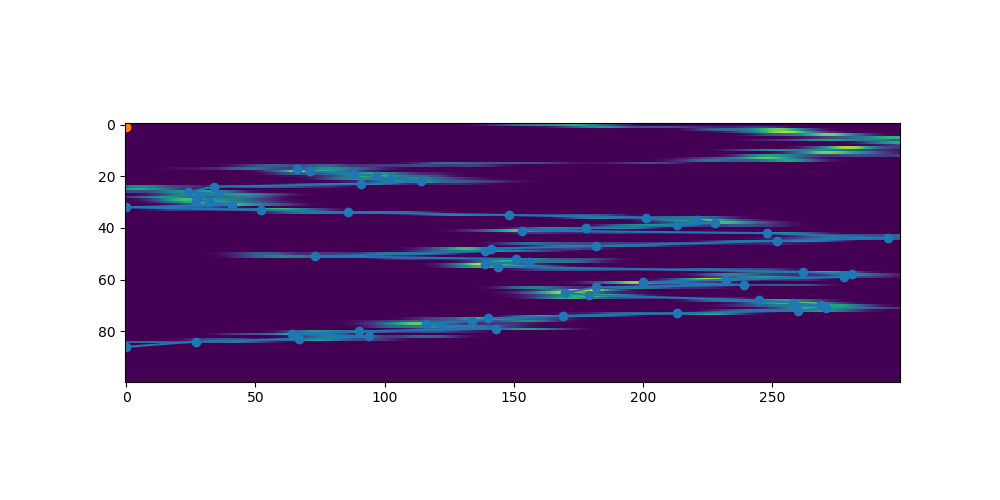

In [17]:
figure_with_selected_trajectory = plt.figure(figsize=(10,5))
axes_with_selected_trajectory = plt.axes()

trajectory = pt.trajectories[3]

pt.plot_averaged_intensity(ax=axes_with_selected_trajectory)
trajectory.plot_trajectory(ax=axes_with_selected_trajectory,marker='o')

# Plot mean square displacement function

<IPython.core.display.Javascript object>


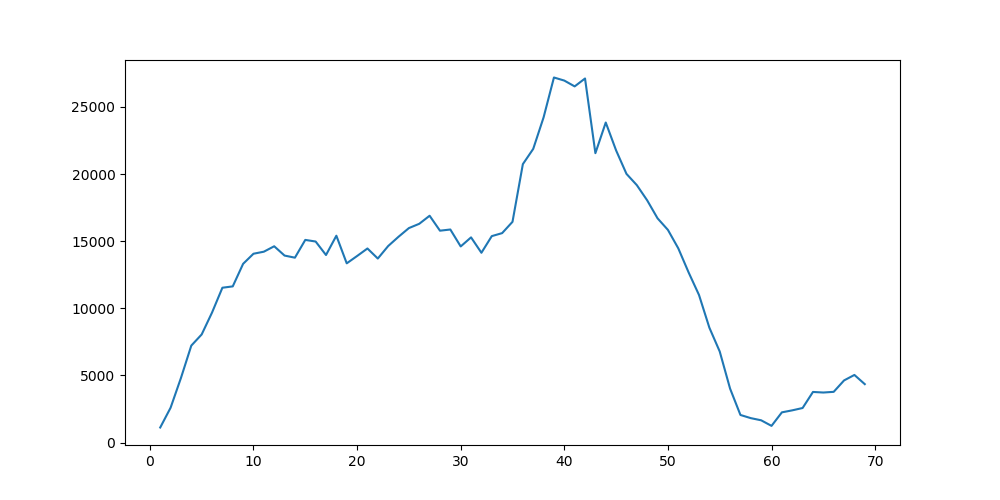

In [19]:
figure_with_mean_square_displacement_function = plt.figure(figsize=(10,5))
axes_with_mean_square_displacement_function = plt.axes()

time, mean_square_displacement = trajectory.calculate_mean_square_displacement_function()

axes_with_mean_square_displacement_function.plot(time, mean_square_displacement)

# Calculate the diffusion coefficient from the mean square displacement function

In [21]:
diffusion_coefficient, error = trajectory.calculate_diffusion_coefficient_from_mean_square_displacement_function()
print(diffusion_coefficient)
print(error)

-18.97092568396086
10.526480874025413


# Save data

In [90]:
trajectory_file_name = filename[0:-4] + '_trajectory_2.mat'
particle_positions = pt.trajectories[dropdown_trajectories.value-2]._particle_positions
data = {
    'frame_index': particle_positions[:,0],
    'position_index': particle_positions[:,1]
}
scipy.io.savemat('data/'+trajectory_file_name, data)